In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import mesa

In [2]:
import mesa
from mesa.visualization import SolaraViz, make_plot_component, make_space_component

print(f"Mesa version: {mesa.__version__}")


def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


def update_expectation(expected_outcome, outcome, alpha):
    expected_outcome += alpha * (outcome - expected_outcome)
    return expected_outcome



boost = 0.10
middle = 0.10
scaler = 0.02
expected = 0.5
alpha = 0.1
beta = 0.05

class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        """initialize a MoneyAgent instance.

        Args:
            model: A model instance
        """
        super().__init__(model)
        self.skill = np.clip(np.random.normal(loc=0.5, scale=0.2), 0, 1)
        self.ability = 0
        self.wins = 1
        self.losses = 1
        self.aichoice = 0
        self.expected = expected
        self.outcome = 0

    def move(self):
        """move to a random neighboring cell."""
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def compete(self):
        """One agent picks another agent randomly and compares scores updating all info"""
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)

            self.expected = update_expectation(self.expected, self.outcome, alpha)
            self.aichoice = np.random.choice([0, 1], p=[1 - self.expected, self.expected])

            other.expected = update_expectation(other.expected, other.outcome, alpha)
            other.aichoice = np.random.choice([0, 1], p=[1 - other.expected, other.expected])

            self.ability = self.skill + self.aichoice * boost + np.clip(np.random.normal(loc= middle , scale= scaler ), 0, 1)
            other.ability = other.skill + other.aichoice * boost + np.clip(np.random.normal(loc= middle , scale= scaler ), 0, 1)
            self.skill = self.skill + ( (-1)**self.aichoice ) * beta
            if self.ability > other.ability:
                self.wins += 1
                self.outcome = 1 * self.aichoice

            else:
                self.losses += 1
                self.outcome = 1 - self.aichoice




    def step(self):
        """do one step of the agent."""
        self.move()
        self.compete()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n=10, width=10, height=10, seed=None):
        """Initialize a competition instance.

        Args:
            N: The number of agents.
            width: width of the grid.
            height: Height of the grid.
        """
        super().__init__(seed=seed)
        self.num_agents = n
        self.grid = mesa.space.MultiGrid(width, height, True)

        # Create agents
        agents = MoneyAgent.create_agents(model=self, n=n)
        # Create x and y positions for agents
        x = self.rng.integers(0, self.grid.width, size=(n,))
        y = self.rng.integers(0, self.grid.height, size=(n,))
        for a, i, j in zip(agents, x, y):
            # Add the agent to a random grid cell
            self.grid.place_agent(a, (i, j))

        self.datacollector = mesa.DataCollector(
            agent_reporters={
                "Skill": "skill",
                "Ability": "ability",
                "Wins": "wins",
                "Losses": "losses",
                "AI Usage Choice": "aichoice",
                "Expected": "expected",
                "Outcome": "outcome"
            }
        )
        self.datacollector.collect(self)

    def step(self):
        """do one step of the model"""
        self.agents.shuffle_do("step")
        self.datacollector.collect(self)

Mesa version: 3.1.4


In [17]:
model = MoneyModel(100)
for _ in range(200):
    model.step()


data = model.datacollector.get_agent_vars_dataframe()
# Use seaborn

In [18]:


data

Skill   Ability  Wins  Losses  AI Usage Choice  Expected  \
Step AgentID                                                                
0    1        0.583099  0.000000     1       1                0  0.500000   
     2        0.484430  0.000000     1       1                0  0.500000   
     3        0.516958  0.000000     1       1                0  0.500000   
     4        0.071007  0.000000     1       1                0  0.500000   
     5        0.470778  0.000000     1       1                0  0.500000   
...                ...       ...   ...     ...              ...       ...   
200  96      -0.189851 -0.008514    43      75                1  0.294598   
     97       1.550246  1.618812    70      66                0  0.573856   
     98       0.991157  1.007317    64      61                0  0.691721   
     99      -0.001706  0.175323    43      88                1  0.723900   
     100      0.650357  0.707671    30      93                0  0.338738   

              Outcome  
Step AgentID           
0    1              0  
     2              0  
     3              0  
     4              0  
     5              0  
...               ...  
200  96             0  
     97             0  
     98             0  
     99             1  
     100            0  

[20100 rows x 7 columns]

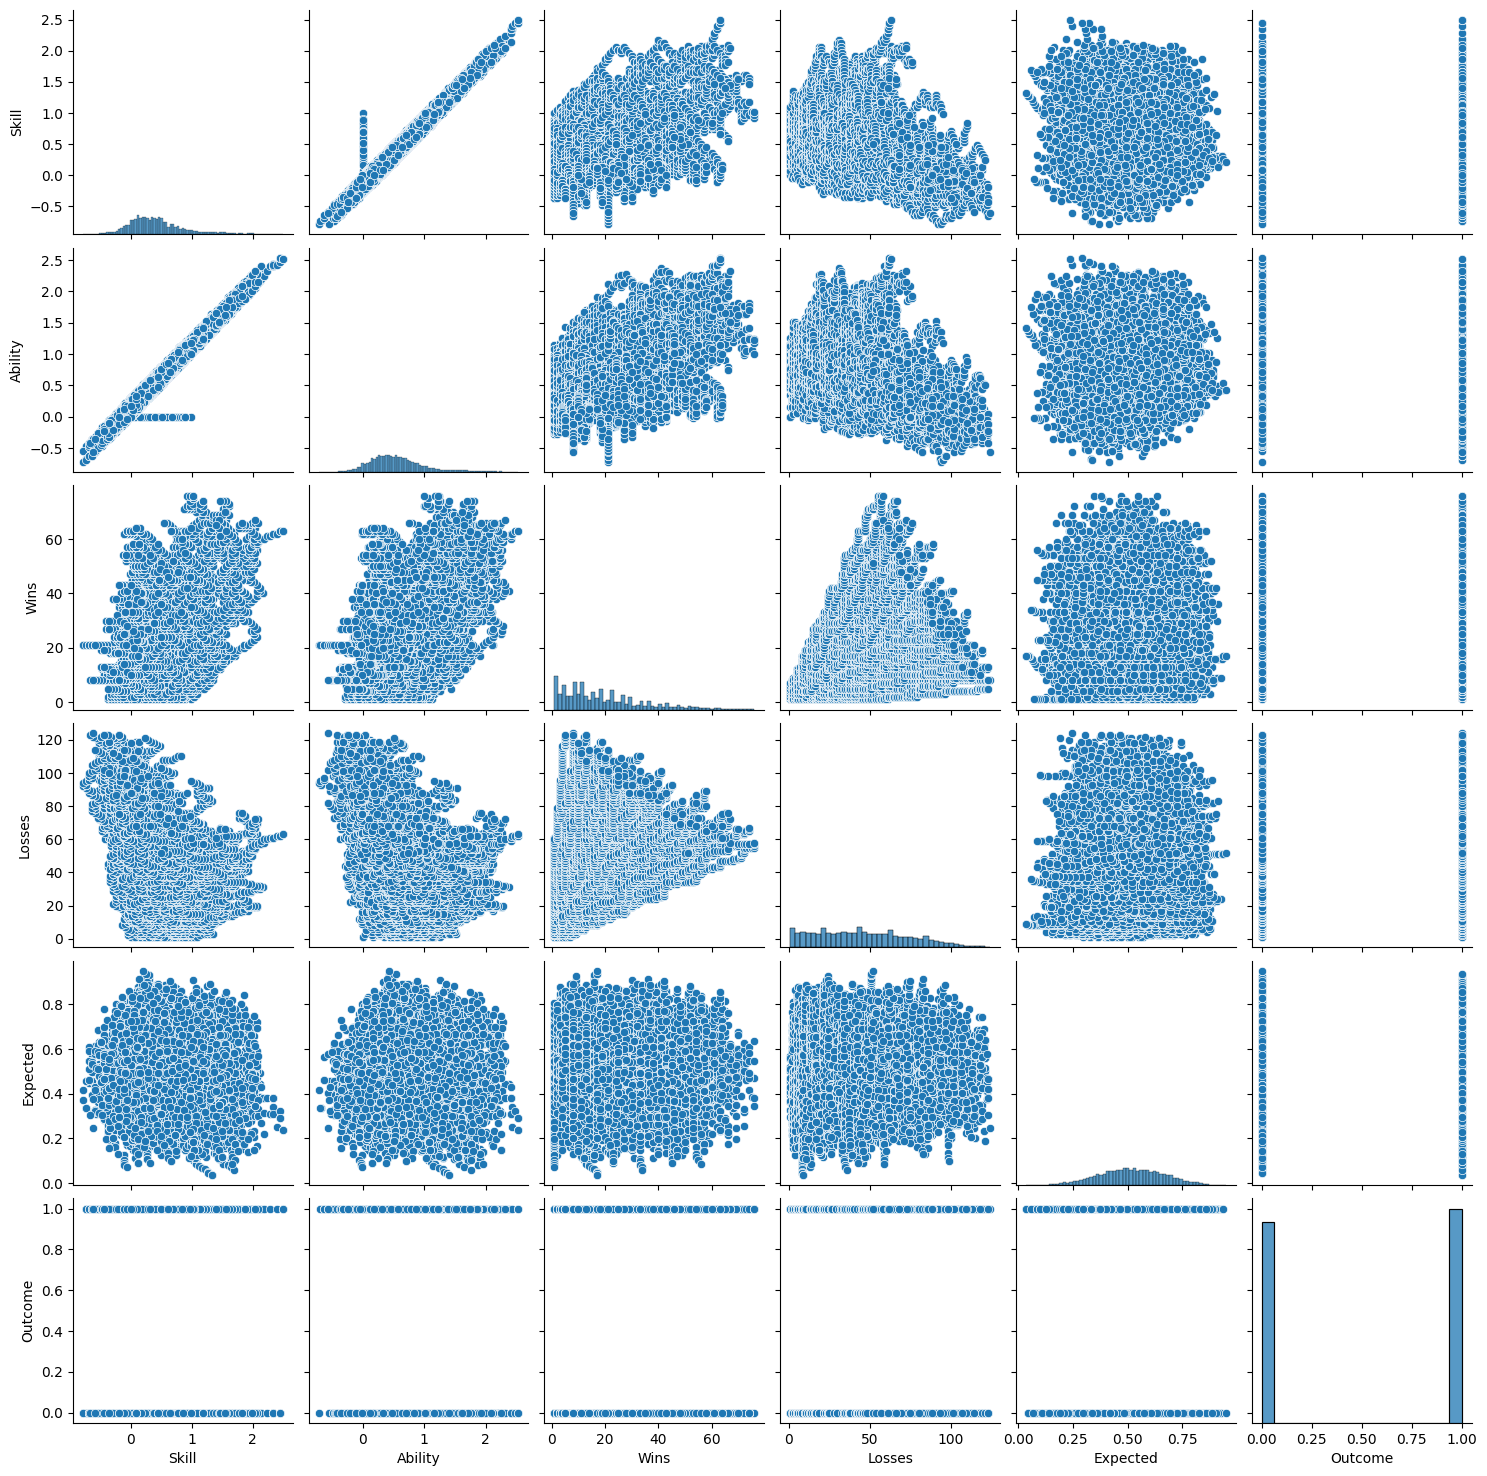

In [19]:
sns.pairplot(data[['Skill', 'Ability', 'Wins', 'Losses', 'Expected', 'Outcome']])
plt.show()

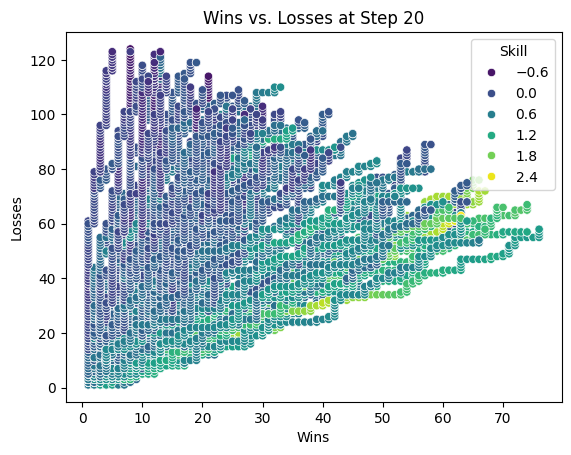

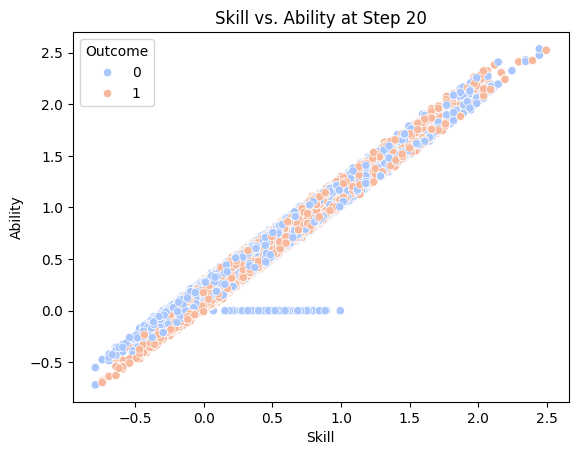

In [24]:
sns.scatterplot(data=data, x='Wins', y='Losses', hue='Skill', palette='viridis')
plt.title('Wins vs. Losses at Step 20')
plt.show()

# Scatter plot for Skill vs Ability at the final step (Step 20)
sns.scatterplot(data=data, x='Skill', y='Ability', hue='Outcome', palette='coolwarm')
plt.title('Skill vs. Ability at Step 20')
plt.show()

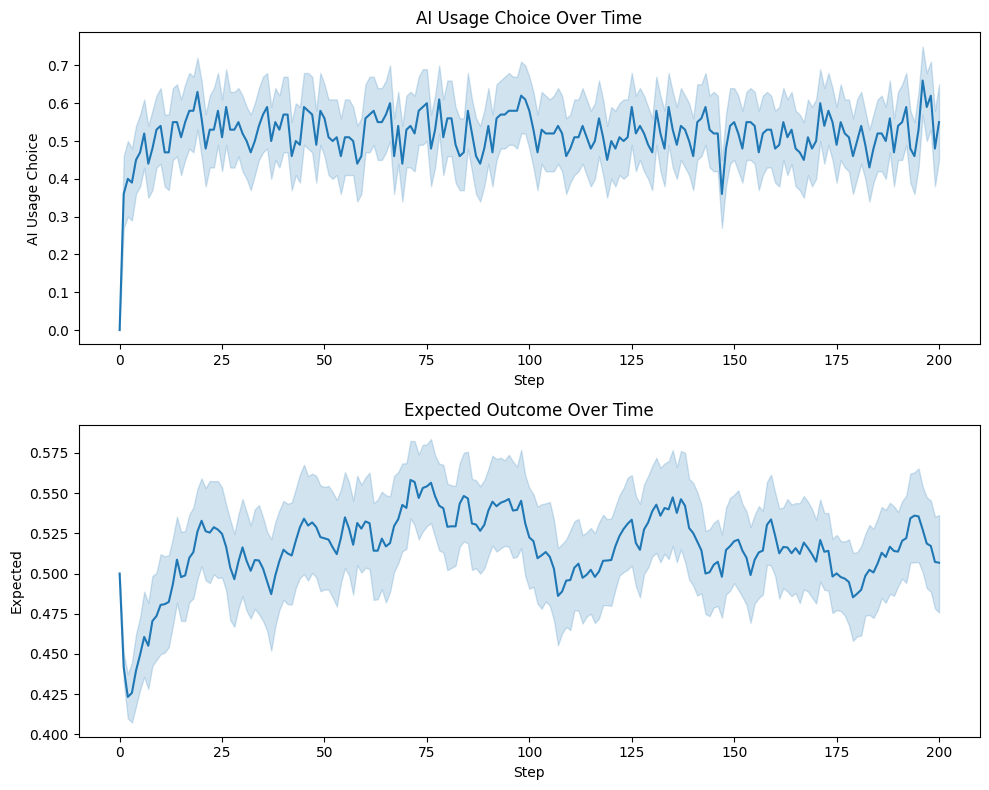

In [22]:
# Line plot for AI Usage Choice and Expected Outcome over time
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot AI Usage Choice
sns.lineplot(data=data, x="Step", y="AI Usage Choice", ax=axes[0])
axes[0].set_title('AI Usage Choice Over Time')

# Plot Expected Outcome
sns.lineplot(data=data, x="Step", y="Expected", ax=axes[1])
axes[1].set_title('Expected Outcome Over Time')

plt.tight_layout()
plt.show()

AttributeError: 'Element' object has no attribute 'render'